# Filter Code

This notebook holds the classes and associated methods to run noisy data through a simulated filter, analyze agreements with ground truth data, and graph the analysis. Filters are built from integrators and their parameters are optimized. 

## Modules and Libraries

Scipy has Runga-Kutta integrators which are used for timestepping (we use RK-45, but other schemes are compatible and can be used), while we use the curve_fit optimizer to optimize the filter's parameters. MatPlotLib is used for graphing, and NumPy is used for data handling. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
from typing import Optional
import os


## Filter Classes

The two classes of filters used are the timestepped filters (directly derived from circuit lowpass and highpass filters) and Butterworth filters (obtained from the scipy library). The timestepped filters are integrated using a Runga-Kutta 45 scheme, but can suffer from phase shift at the cost of high resolution. Butterworth filters feature a steeper cutoff at critical frequncies but can be susceptible to reverberation. scipy.optimize.curve_fit tends to find local minima, so sampling over a acceptably large domain is manually implemented. Error is quantified using Mean Squared Error. 

In [2]:
#root class for all filters
class Filters:
    def __init__(self, tspan, signal):
        self.tspan = tspan
        self.signal = signal
    
    #used to find nearest time index for RK45 integrator
    def find_nearest(self, array, value):
        idx = np.searchsorted(array, value, side='left')
        if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
            return idx-1
        else:
            return idx
    
    #mean squared error of filtered against ground truth
    def relErr(self, filtered, truth):
        diff = np.empty_like(filtered)
        diff = filtered - truth
        diffmag = np.linalg.norm(diff)
        return diffmag**2/diff.size

## Time Stepped Filters

These are directly implemented by solving the differential equations governming circuit lowpass and highpass filters. Bandpass is a lowpass chained together with a highpass filter. These equations are derived from the following:
- The sum of potential differences around a loop in a circuit must be zero (Kirchoff's Loop Rule)
- The sum of currents entering a junction is equal to the sum of currents leaving the junction (Kirchoff's Junction Rule) 
- Capacitor Voltage: $\frac{dV}{dt} = \frac{1}{C}I$
- Inductor Voltage: $V = L\frac{dI}{dt}$
- Resistor Voltage: $V = IR$

In [3]:
#directly transferred from circuits        
class TimesteppedFilters(Filters):
    
    #returns function derivative at discrete points for timestepping(tspan)
    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)
        
    def lowpassdisc(self, t, y, signal, tau):
        dydt = (1/tau)*(signal[self.find_nearest(self.tspan, t)]-y)
        return dydt
    
    def highpassdisc(self, t, y, signal, tau):
        dydt = (signal[self.find_nearest(self.tspan, t)]+
                signal[self.find_nearest(self.tspan, t)-1])/(self.tspan[self.find_nearest(self.tspan, t)]
                -self.tspan[self.find_nearest(self.tspan, t)-1])-y/tau
        return dydt       

    #integrators for filter equations
    def solvelow(self, tau, scale):
        sol_low = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], 
                                                                               self.tspan[-1]],[0], 
                            t_eval=self.tspan, args=[self.signal, tau])
        return sol_low.y[0, :]
    
    def solvehigh(self, tau, scale):
        sol_high = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                 self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[self.signal, tau])
        return sol_high.y[0]
    
    def solvebandpass(self, tau1, tau2, scale):
        lowpass = self.solvelow(tau1).y[0]
        bandpass = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                 self.tspan[-1]],[0], 
                             t_eval=self.tspan, args=[lowpass, tau2])
        return bandpass.y[0]
    
    #crude minimal global error
    def optSolve(self, truth, ftype):
        if ftype=='lowpass':
            params = np.empty(2)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], 
                                                                               self.tspan[-1]],y0=[self.signal[0]], 
                            t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.075
            minscale = np.max(truth)/np.max(sol.y[0])
            minerr = self.relErr(sol.y[0]*minscale, truth)
            for n in range(2, 50):
                tau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], 
                                                                                   self.tspan[-1]],y0=[self.signal[0]], 
                            t_eval=self.tspan, args=[self.signal, tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = scale*sol.y[0]
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-mapscale)/mapscale > len(soln)-1:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err)**2/err.size < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = minscale
            params[1] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.lowpassdisc(t, y, *args),[self.tspan[0], 
                                                                                     self.tspan[-1]],y0=[self.signal[0]], 
                            t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = minscale*bestsolve.y[0]
            return bestsolve, params
        
        elif ftype=='highpass':
            params = np.empty(2)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                self.tspan[-1]],y0=[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
            mintau = 0.075
            minscale = np.max(truth)/np.max(sol.y[0])
            minerr = self.relErr((sol.y[0]), truth)
            for n in range(2, 20):
                gtau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                    self.tspan[-1]],y0=[0], 
                            t_eval=self.tspan, args=[self.signal, tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = sol.y[0]*scale
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-scale)/scale > len(scale)-2:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err)**2/err.size < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = minscale
            params[1] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                      self.tspan[-1]],y0=[0], 
                            t_eval=self.tspan, args=[self.signal, mintau])  
            bestsolve.y[0] = bestsolve.y[0]*minscale
            bestsolve.y[0][0] = bestsolve.y[0][1]
            return bestsolve, params            
        
        elif ftype=='bandpass':
            low, lowparam = self.optSolve(truth, ftype='lowpass')
            params = np.empty(4)
            tau = 0.075
            sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                self.tspan[-1]],y0=[0], 
                            t_eval=self.tspan, args=[low.y[0], tau])  
            mintau = 0.075
            minscale = np.max(truth)/np.max(sol.y[0])
            minerr = self.relErr((sol.y[0]*minscale), truth)
            for n in range(2, 50):
                gtau = n*0.075
                sol = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                    self.tspan[-1]],y0=[0], 
                            t_eval=self.tspan, args=[low.y[0], tau])  
                scale = np.max(truth)/np.max(sol.y[0])
                soln = scale*sol.y[0]
                if len(soln)< len(truth):
                    err = np.empty_like(truth)
                    mapscale = len(truth)/len(soln)
                    for idx in range(err):
                        if math.ceil(idx-scale)/scale > len(scale)-2:
                            err[idx] = truth[idx]-soln[-1]
                        else:
                            err[idx] = truth[idx] - soln[math.ceil(idx/mapscale)]
                else:
                    err = np.empty_like(truth)
                    err = truth - soln
                    
                if np.linalg.norm(err)**2/err.size < minerr:
                    mintau = tau
                    minscale = scale
            params[0] = lowparam[0]
            params[1] = lowparam[1]
            params[2] = minscale
            params[3] = mintau
            bestsolve = solve_ivp(lambda t, y, *args: self.highpassdisc(t, y, *args),[self.tspan[0], 
                                                                                      self.tspan[-1]],y0=[0], 
                                                                                      t_eval=self.tspan, 
                                                                                      args=[low.y[0], mintau]) 
            bestsolve.y[0] = minscale*bestsolve.y[0]
            bestsolve.y[0][0] = bestsolve.y[0][1]
            return bestsolve, params

    #graphing filtration, option to graph alongside truth signal
    def graph(self, opt, ftype, truth=None):
        sol = opt[0]
        params = opt[1]
        plt.plot(sol.t, sol.y[0,:], label='Filtered')
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label='Ground truth')
        if ftype=='Low Pass' or ftype=='High Pass':
            plt.title('%s, RK45 Integrator, Params [Scale: %f, Tau: %f]' % (ftype, params[0], params[1]))
        elif ftype=='Band Pass':
            plt.title('%s, RK45 Integrator, Params [Scales: %f, %f, Taus: %f, %f]' % (ftype, 
                                                                                     params[0], 
                                                                                     params[2], 
                                                                                     params[1], 
                                                                                     params[3]))    
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.show()

## Butterworth Filters

These filters are not directly derived to integrate, but rather are from scipy's signal library. Butterworth filters differ from time-stepped filters due to their sharper frequency cutoff. The steepness of the Butterworth cutoff allows less noise, but makes them susceptible to increased reverberative effects. Similar to the timestepped filters, sampling is manually instituted over an acceptably large domain. 

Another filter type we are considering are the Chebyshev class of filters. We may institute these later if these filters do not prove effective at increasing basecalling single-read accuracy. 

In [4]:
#digital Butterworth Filters        
class ButterworthFilters(Filters):

    def __init__(self, tspan, signal):
        super().__init__(tspan, signal)  
    
    #Butterworth filter solvers for input parameters
    def lbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='lowpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def hbutt(self, t, order, freq0):
        order = int(order)
        freqarray = np.empty(1)
        freqarray[0] = freq0
        b, a = signal.butter(order, freqarray, btype='highpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bpassbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandpass')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)]
    
    def bstopbutt(self, t, order, freq0, freq1):
        order = int(order)
        freqarray = np.empty(2)
        freqarray[0] = freq0
        freqarray[1] = freq1
        b, a = signal.butter(order, freqarray, btype='bandstop')
        y = signal.filtfilt(b, a, self.signal)
        return y[np.where(self.tspan==t)] 
   
    # Optimizes Butterworth filter parameters, sampling over whole domain for global minima
    def optSolve(self, orders, truth, ftype):
        if ftype=='lowpass':             
            popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[1, 0.5], 
                                   bounds=(0, [np.inf, 0.99]))
            minerr = self.relErr(self.lbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.lbutt, self.tspan, truth, p0=[order, 0.5], 
                                       bounds=(0, [np.inf, 0.99]))
                err = self.relErr(self.lbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.lbutt, self.tspan, truth, p0=[minorder, 0.5], 
                                         bounds=(0, [np.inf, 0.99]))
            y = self.lbutt(self.tspan, *minpopt)
            return y, minpopt
            
        elif ftype=='highpass':  
            popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[1, 0.01], 
                                   bounds=(0, [np.inf, 0.99]))
            minerr = self.relErr(self.hbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.hbutt, self.tspan, truth, p0=[order, 0.01], 
                                       bounds=(0, [np.inf, 0.99]))
                err = self.relErr(self.hbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.hbutt, self.tspan, truth, p0=[minorder, 0.01], 
                                         bounds=(0, [np.inf, 0.99]))
            y = self.hbutt(self.tspan, *minpopt)
            return y, minpopt                
           
        elif ftype=='bandpass':  
            popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[1, 0.01, 0.99], 
                                   bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = self.relErr(self.bpassbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[order, 0.01, 0.99], 
                                       bounds=(0, [np.inf, 0.99, 0.99]))
                err = self.relErr(self.bpassbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bpassbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], 
                                         bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bpassbutt(self.tspan, *minpopt)
            return y, minpopt 
        
        elif ftype=='bandstop':  
            popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[1, 0.01, 0.99], 
                                   bounds=(0, [np.inf, 0.99, 0.99]))
            minerr = self.relErr(self.bstopbutt(self.tspan, *popt), truth)
            minorder = 1
            for order in range (2, orders):
                popt, pcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[order, 0.01, 0.99], 
                                       bounds=(0, [np.inf, 0.99, 0.99]))
                err = self.relErr(self.bstopbutt(self.tspan, *popt), truth)
                if (err < minerr):
                    minorder = order
                    minerr = err
            minpopt, minpcov = curve_fit(self.bstopbutt, self.tspan, truth, p0=[minorder, 0.01, 0.99], 
                                         bounds=(0, [np.inf, 0.99, 0.99]))
            y = self.bstopbutt(self.tspan, *minpopt)
            return y, minpopt 
    
    # Graphing filtration, option to graph alongside truth signal
    def graph(self, y, popt, ftype, truth=None):
        plt.plot(self.tspan, y, label='Filtered')
        if truth is not None:
            plt.plot(self.tspan, truth,'--', label='Ground truth')
        if ftype=='Low Pass' or ftype=='High Pass':
            plt.title('Bandworth type: %s, Params [Ord: %d, Freq: %f]' % (ftype, int(popt[0]), popt[1]))
        elif ftype=='Band Pass' or ftype=='Band Stop':
            plt.title('Bandworth type: %s, Params [Ord: %d, Freqs: %f, %f]' % (ftype, int(popt[0]), 
                                                                              popt[1], popt[2]))
        plt.legend(loc='upper right')
        plt.margins(0.05, 0.4)
        plt.show()

# Potential Chebyshev filters to add in the future:

#b, a = scipy.signal.cheby1(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan,  y)

#b, a = scipy.signal.cheby2(1, 20, 0.2)
#y = scipy.signal.filtfilt(b, a, Vinarray)
#plt.plot(tspan, y)

## Examples

The 1st signal to extract is a simple, continuous sine wave, but we add copious noise to the waveform at a variety of frequencies.

The 2nd signal is a periodic square wave with noise. This resembles the type of data we would be working with a bit better.

We run the signals through the filters, optimize their parameters to fit against the ground truth, and graph the results with parameter labels in order to analyze which filters appear most effective.

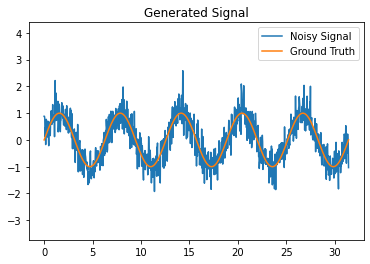

Error Magnitude:  0.06131383640042882


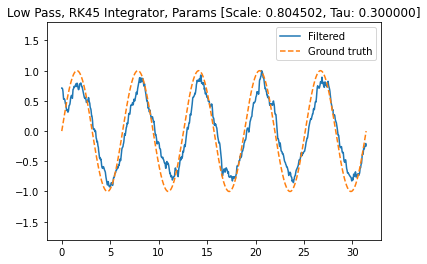

Error Magnitude:  0.06056448885016974


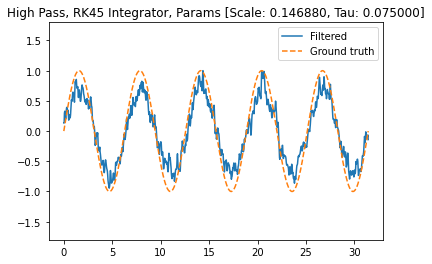

Error Magnitude:  0.07550031544137953


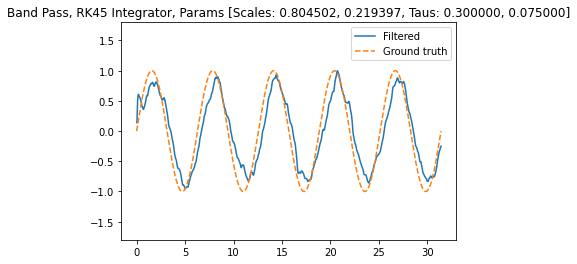

Error Magnitude:  0.009106475024686521


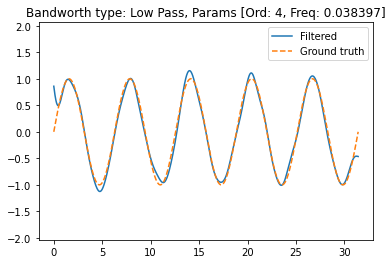

Error Magnitude:  0.21232165039629144


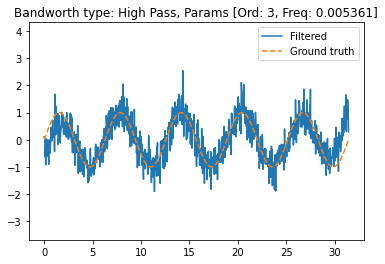

Error Magnitude:  0.04033748255556392


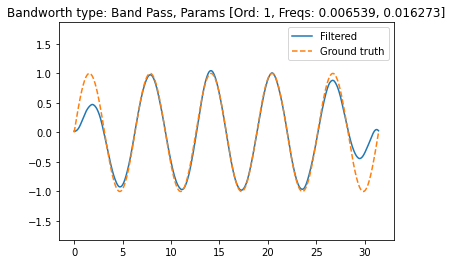

Error Magnitude:  0.012842022435678257


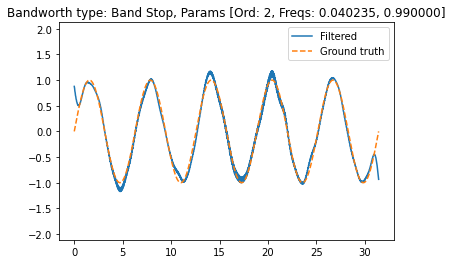

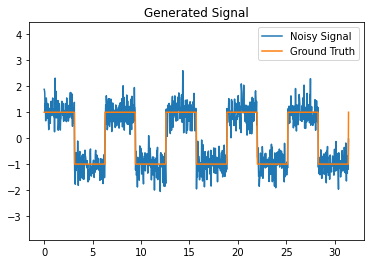

Error Magnitude:  0.26036076808131414


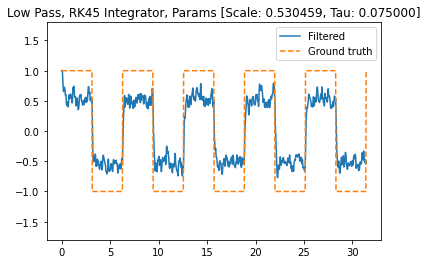

Error Magnitude:  0.17192466501579257


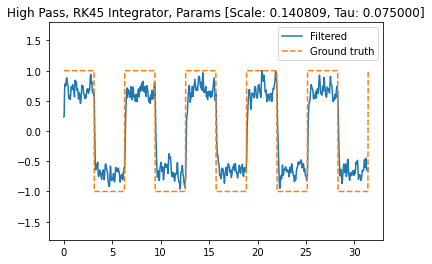

Error Magnitude:  0.19282562157568736


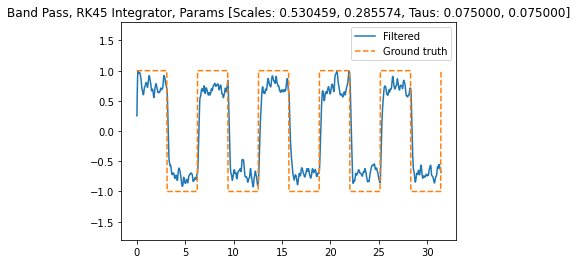

Error Magnitude:  0.03890877112873619


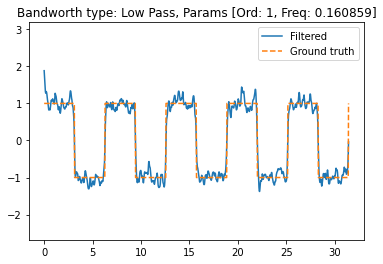

Error Magnitude:  0.24391569038585806


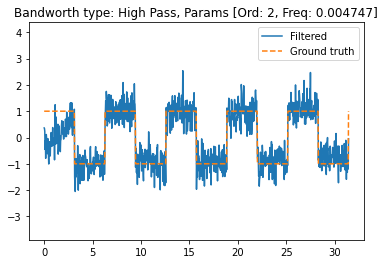

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [5]:
# Filter simulations and graphing
# Only code user needs to access all filters

if __name__ == '__main__':
    
    #Generating example noisy signal
    np.random.seed(123456789)
    tspan =  np.linspace(0, 10*np.pi, 1000)
    teval = 0
    Vin = lambda t: np.sin(t)
    mynoise = 0.4*np.random.randn(*Vin(tspan).shape)
    Vinarray = Vin(tspan) + mynoise
    
    plt.plot(tspan, Vinarray, label='Noisy Signal')
    plt.plot(tspan, Vin(tspan), label='Ground Truth')
    plt.legend(loc='upper right')
    plt.margins(0.05, 0.4)
    plt.title('Generated Signal')
    plt.show()
     
    
    #filtering
    filtered = TimesteppedFilters(tspan, Vinarray)
    lowfilter = filtered.optSolve(Vin(tspan), ftype='lowpass')
    print('Error Magnitude: ', filtered.relErr(lowfilter[0].y[0,:], Vin(tspan)))
    filtered.graph(lowfilter, 'Low Pass', Vin(tspan))

    highfilter = filtered.optSolve(Vin(tspan), ftype='highpass')
    print('Error Magnitude: ', filtered.relErr(highfilter[0].y[0,:], Vin(tspan)))
    filtered.graph(highfilter, 'High Pass', Vin(tspan))

    bandpassfilter = filtered.optSolve(Vin(tspan), ftype='bandpass')
    print('Error Magnitude: ', filtered.relErr(bandpassfilter[0].y[0,:], Vin(tspan)))
    filtered.graph(bandpassfilter, 'Band Pass', Vin(tspan))
    
    butterworth = ButterworthFilters(tspan, Vinarray)
    butterlow = butterworth.optSolve(10, Vin(tspan), ftype='lowpass')
    print('Error Magnitude: ', butterworth.relErr(butterlow[0], Vin(tspan)))
    butterworth.graph(butterlow[0], butterlow[1], 'Low Pass', truth=Vin(tspan))
    
    butterhigh = butterworth.optSolve(10, Vin(tspan), ftype='highpass')
    print('Error Magnitude: ', butterworth.relErr(butterhigh[0], Vin(tspan)))
    butterworth.graph(butterhigh[0], butterhigh[1], 'High Pass', truth=Vin(tspan))
    
    butterbpass = butterworth.optSolve(10, Vin(tspan), ftype='bandpass')
    print('Error Magnitude: ', butterworth.relErr(butterbpass[0], Vin(tspan)))
    butterworth.graph(butterbpass[0], butterbpass[1], 'Band Pass', truth=Vin(tspan))

    butterbstop = butterworth.optSolve(10, Vin(tspan), ftype='bandstop')
    print('Error Magnitude: ', butterworth.relErr(butterbstop[0], Vin(tspan)))
    butterworth.graph(butterbstop[0], butterbstop[1],'Band Stop', truth=Vin(tspan))
    
    
    sqwave = signal.square(tspan)
    sqnoisywave = mynoise+sqwave
    plt.plot(tspan, sqnoisywave, label='Noisy Signal')
    plt.plot(tspan, sqwave, label='Ground Truth')
    plt.legend(loc='upper right')
    plt.margins(0.05, 0.4)
    plt.title('Generated Signal')
    plt.show()
    
    sqfiltered = TimesteppedFilters(tspan, sqnoisywave)
    sqlowfilter = sqfiltered.optSolve(sqwave, ftype='lowpass')
    print('Error Magnitude: ', sqfiltered.relErr(sqlowfilter[0].y[0,:], sqwave))
    filtered.graph(sqlowfilter, 'Low Pass', sqwave)
    
    sqhighfilter = sqfiltered.optSolve(sqwave, ftype='highpass')
    print('Error Magnitude: ', sqfiltered.relErr(sqhighfilter[0].y[0,:], sqwave))
    filtered.graph(sqhighfilter, 'High Pass', sqwave)
    
    sqbandpassfilter = sqfiltered.optSolve(sqwave, ftype='bandpass')
    print('Error Magnitude: ', sqfiltered.relErr(sqbandpassfilter[0].y[0,:], sqwave))
    filtered.graph(sqbandpassfilter, 'Band Pass', sqwave)
    
    sqbutter = ButterworthFilters(tspan, sqnoisywave)
    sqbutterlow = sqbutter.optSolve(10, sqwave, ftype='lowpass')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterlow[0], sqwave))
    sqbutter.graph(sqbutterlow[0], sqbutterlow[1], 'Low Pass', truth=sqwave)
    
    sqbutterhigh = sqbutter.optSolve(10, sqwave, ftype='highpass')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterhigh[0], sqwave))
    sqbutter.graph(sqbutterhigh[0], sqbutterhigh[1], 'High Pass', truth=sqwave)
    
    sqbutterbpass = sqbutter.optSolve(10, sqwave, ftype='bandpass')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterbpass[0], sqwave))
    sqbutter.graph(sqbutterbpass[0], sqbutterbpass[1], 'Band Pass', truth=sqwave)
    
    sqbutterbstop = sqbutter.optSolve(10, sqwave, ftype='bandstop')
    print('Error Magnitude: ', sqbutter.relErr(sqbutterbstop[0], sqwave))
    butterworth.graph(sqbutterbstop[0], sqbutterbstop[1],'Band Stop', truth=sqwave)

## Example Analysis

In this example, highpass is not an effective filter, as we would expect. This makes sense because we are trying to extract a low frequency signal. With the nanopore DNA sequencing data however, we are generally going to be reconstructing square waves from soft, gradual curves, so the high pass should prove more effective there (square waves are the infinite sum of odd harmonics of sin waves).